## Important

In [181]:
import numpy as np
from skimage.segmentation import slic
from skimage.color import rgb2gray
from scipy.ndimage import center_of_mass

def convert_image_array_to_slic_with_properties(image_array,binary_array, n_segments=100, compactness=10, sigma=1):
    """
    Convert an image array to a segmented grayscale image using SLIC (Simple Linear Iterative Clustering) algorithm,
    and calculate properties for each superpixel including color, centroid x, centroid y, and number of pixels.

    Args:
        image_array (numpy.ndarray): Input image array in black and white.
        n_segments (int, optional): Number of segments in SLIC. Default is 100.
        compactness (float, optional): Compactness parameter for SLIC. Default is 10.
        sigma (float, optional): Sigma parameter for SLIC. Default is 1.

    Returns:
        segmented_image_gray (numpy.ndarray): Segmented grayscale image.
        properties (numpy.ndarray): Array of dictionaries containing properties for each superpixel.
    """
    image_rgb = np.stack((image_array,) * 3, axis=-1)
    segments = slic(image_rgb, n_segments=n_segments, compactness=compactness, sigma=sigma)
    segmented_image = np.zeros_like(image_rgb)
    properties = []  # List to store properties

    for segment_id in np.unique(segments):
        mask = segments == segment_id
        segment_rgb = image_rgb[mask]

        if np.any(mask):
            num_pixels = np.sum(mask)
            centroid = center_of_mass(mask)
            centroid_x, centroid_y = centroid
            mean_color = np.mean(segment_rgb, axis=0)

            properties.append({
                'color': mean_color, # RGB color values
                'centroid_x': centroid_x, # x coordinate of centroid
                'centroid_y': centroid_y, # y coordinate of centroid
                'num_pixels': num_pixels # number of pixels in superpixel
            })

            segmented_image[mask] = mean_color
    
    properties = np.array(properties)  # Convert properties list to numpy array

    segmented_image_gray = rgb2gray(segmented_image) # Convert segmented image to grayscale
    
    labels = []
    for prop in properties:
        x, y = int(prop['centroid_x']), int(prop['centroid_y'])
        binary_color = binary_array[x, y]  # Assuming binary_array has the same dimensions as the image
        label = 1 if binary_color == 1 else 0
        labels.append(label)
    # properties.append(labels)
    return segmented_image_gray, properties,labels


In [182]:
true=rasterio.open("B02.tif").read(1)
label=rasterio.open("labels.tif").read(1)

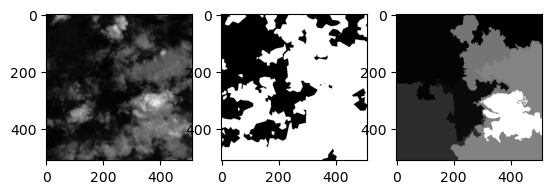

In [178]:
plt.subplot(1,3,1)
plt.imshow(true,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(label,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(convert_image_array_to_slic_with_properties(image_array=true,binary_array=label,n_segments=10)[0],cmap='gray')

In [186]:
convert_image_array_to_slic_with_properties(image_array=true,binary_array=label,n_segments=10)[1:3]

(array([{'color': array([1327.44737155, 1327.44737155, 1327.44737155]), 'centroid_x': 129.11721287777004, 'centroid_y': 114.96324767428017, 'num_pixels': 58799},
        {'color': array([3583.98665643, 3583.98665643, 3583.98665643]), 'centroid_x': 135.92355779776267, 'centroid_y': 304.37753162243183, 'num_pixels': 27354},
        {'color': array([1228.81722137, 1228.81722137, 1228.81722137]), 'centroid_x': 50.193388954384695, 'centroid_y': 401.64051872676157, 'num_pixels': 22054},
        {'color': array([3868.31518864, 3868.31518864, 3868.31518864]), 'centroid_x': 216.35987748851454, 'centroid_y': 436.5516149241264, 'num_pixels': 28732},
        {'color': array([1450.46410615, 1450.46410615, 1450.46410615]), 'centroid_x': 316.1555865921788, 'centroid_y': 251.94571694599628, 'num_pixels': 21480},
        {'color': array([2121.28941095, 2121.28941095, 2121.28941095]), 'centroid_x': 388.3525069209474, 'centroid_y': 104.2342163949554, 'num_pixels': 52016},
        {'color': array([6338.22

## DONT CARE

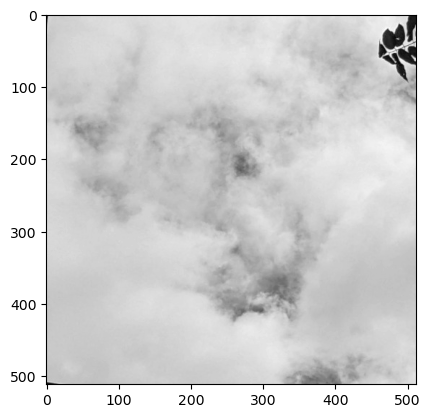

In [26]:
# Usage

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Load the JPEG image using PIL
image_path = 'gg.jpeg'  # Replace with the actual path to your JPEG image
image = Image.open(image_path)

# Convert the PIL image to a numpy array
image_arr = np.array(image)
image_arr=rgb2gray(image_arr)
plt.imshow(image_arr, cmap='gray')

In [114]:
import glob
import rasterio
import matplotlib.pyplot as plt

# Define the path to the folders containing the .tif files
path_to_folders = "D:/Anirudh/LMU DS/Sem2/CV/Project/otclouds/dataset_clouds_from_lwir/dataset_clouds_from_lwir/training/lwir"

# Use glob to find all the folders in the specified path
folder_paths = glob.glob(path_to_folders + "*/")

# Sort the folder paths alphabetically (assuming they are named sequentially)
folder_paths.sort()

# Initialize an empty list to store the first 10 datasets
datasets = []

# Iterate through the first 10 folders
for folder_path in folder_paths[:2]:
    # Use glob to find all .tif files within the folder
    tif_files = glob.glob(folder_path + "*.tif")
    tif_files.sort()  # Sort the .tif files alphabetically

    # Iterate through the .tif files and read them using rasterio
    for tif_file in tif_files:
        with rasterio.open(tif_file) as dataset:
            datasets.append(dataset.read(1))  # Append the data to the list


In [105]:
extreme=rasterio.open("LC08_L1TP_002054_20160520_20170324_01_T1.TIF").read(1)

c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [142]:
import glob
import rasterio
import matplotlib.pyplot as plt

# Define the path to the folders containing the .tif files
path_to_folders = "D:/Anirudh/LMU DS/Sem2/CV/Project/otclouds/dataset_clouds_from_lwir/dataset_clouds_from_lwir/training/lwir/"

# Initialize an empty list to store the first 10 datasets
datasets = []

tif_files = glob.glob(path_to_folders + "*.tif")

# Iterate through the .tif files and read them using rasterio
for tif_file in tif_files[:100]:
    with rasterio.open(tif_file) as dataset:
        datasets.append(dataset.read(1))  # Append the data to the lis



c:\Users\aniru\anaconda3\envs\py39\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


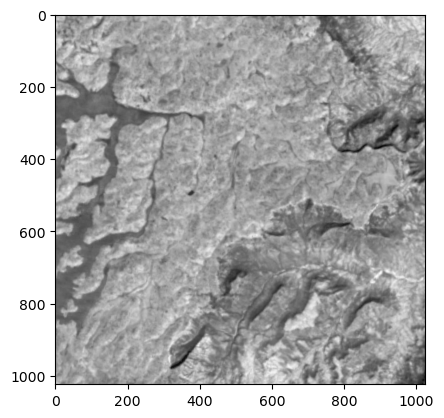

In [154]:
plt.imshow(datasets[77],cmap='gray')

In [133]:
import cv2
image = convert_image_array_to_slic_with_properties(datasets[7],n_segments=500)[0]
## min max scale the image
def min_max_scale(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def plot_thresholded_image(thresh,image=image):
    thresh = cv2.threshold(min_max_scale(image), thresh, 1, cv2.THRESH_BINARY)[1]

    ## Plot thresholded image
    plt.subplot(1,2,1)
    plt.imshow(datasets[7],cmap='gray')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(thresh,cmap='gray')
    plt.title('Thresholded Image')
    plt.show()
        

In [134]:
## Use funtion plot_thresholded_image with a ipython widget to find the best threshold value for the image

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt

    
interact(plot_thresholded_image, image=widgets.fixed(image), thresh=(0, 1, 0.05))

interactive(children=(FloatSlider(value=0.0, description='thresh', max=1.0, step=0.05), Output()), _dom_classe…

<function __main__.plot_thresholded_image(thresh, image=array([[0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       [0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       [0.62436866, 0.62436866, 0.62436866, ..., 0.62317845, 0.62317845,
        0.62317845],
       ...,
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738],
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738],
       [0.61490806, 0.61490806, 0.61490806, ..., 0.65433738, 0.65433738,
        0.65433738]]))>

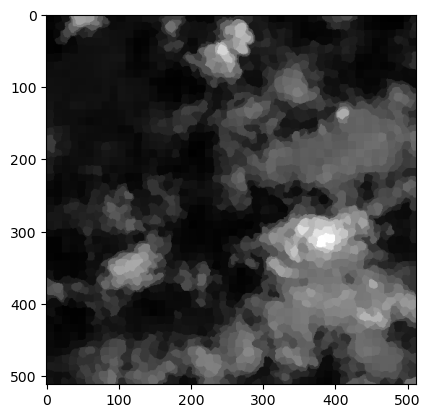

In [63]:
plt.imshow(convert_image_array_to_slic_with_properties(datasets[1],n_segments=2000)[0],cmap='gray')



In [32]:
convert_image_array_to_slic_with_properties(image_arr,n_segments=3)

(array([[0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        [0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        [0.73592292, 0.73592292, 0.73592292, ..., 0.78066068, 0.78066068,
         0.78066068],
        ...,
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407],
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407],
        [0.73805407, 0.73805407, 0.73805407, ..., 0.73805407, 0.73805407,
         0.73805407]]),
 array([{'color': array([0.73592292, 0.73592292, 0.73592292]), 'centroid_x': 180.44556840684635, 'centroid_y': 117.43895917157525, 'num_pixels': 79283},
        {'color': array([0.78066068, 0.78066068, 0.78066068]), 'centroid_x': 125.55159449658703, 'centroid_y': 377.14294475255974, 'num_pixels': 75008},
        {'color': array([0.73805407, 0.73805407, 0.73805407]), 'centroid_x': 401.04727731263847, 'centr